In [1]:
import pandas as pd
import wave
from scipy.signal import butter, filtfilt, lfilter
import soundfile as sf
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
import scipy.io.wavfile as wavfile
import librosa, librosa.display
import noisereduce as nr
from scipy.interpolate import interp1d
from matplotlib import mlab
import os
import tensorflow as tf
from pydub import AudioSegment


/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/__init__.py:104: UserWarning

# Plots

In [57]:
def joint_plots (origen_file, destination_file):
    # Load audio file and apply FFT
    sample_rate, samples = wavfile.read(origen_file)

    fft_values = np.fft.fft(samples)
    fig = plt.figure(figsize=(10, 12))

    # Plot time-domain representation of the audio signal
    ax1 = plt.subplot(311)
    t = np.arange(len(samples)) / float(sample_rate)
    ax1.plot(t, samples)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Time-domain representation')
    ax1.grid()

    # Plot frequency-domain representation of the audio signal: how much each frequency is contributing to overall sound of audio file
    ax2 = plt.subplot(312)
    ax2.plot(abs(fft_values))
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title('Magnitude spectrum plot: Contribution of each frequency')
    ax2.grid()

    # Plot spectrogram of the audio signal
    ax3 = plt.subplot(313)
    t_audio = len(samples)/sample_rate

    # Remove DC offset which is the presence of a non-zero mean value in the audio signal, and it can cause a large spike at 0 Hz in the spectrogram
    # This was done when mean was removed from samples 

    ax3.specgram(samples, Fs=sample_rate, vmin=-20, vmax=50)
    ax3.set_title('Spectogram')
    ax3.set_ylabel('Frequency (Hz)')
    ax3.set_xlabel('Time (s)')
    ax3.set_xlim(0, t_audio)

    # Combine all the plots into a single figure
    plt.tight_layout()
    #plt.savefig(destination_file)
    #plt.show()

# Denoising: spectral

In [3]:
def denoise_spectral_gating(file_name):
    rate, data = wavfile.read(file_name)
    data = data - data.mean()
    # perform noise reduction\n",
    reduced_noise = nr.reduce_noise(y=data, sr=rate, stationary=True)
    return reduced_noise, rate

In [4]:
def save_denoised(reduced_noise, rate, destination_file):
    # because the denoised clips will be used by tf.audio.decode_wav and this only takes 16-bit files, the denoised audios are saved as int16
    # https://stackoverflow.com/questions/64813162/read-wav-file-with-tf-audio-decode-wav
    wavfile.write(destination_file, rate, reduced_noise.astype(np.int16)) 

In [5]:
def apply_denoising(file_name, destination_file):
    reduced_noise, rate = denoise_spectral_gating(file_name)
    save_denoised(reduced_noise, rate, destination_file)

In [46]:
file = '/Users/rosameliacarioni/University/Thesis/code/data/Clips/ecoguns0.wav'
rate, data = wavfile.read(file)
data = data - data.mean()
    # perform noise reduction\n",
reduced_noise = nr.reduce_noise(y=data, sr=rate, stationary=True)
print(data)

[-89.35321821   8.64678179 221.64678179 ...  47.64678179 141.64678179
 -40.35321821]


Apply the denoising to all clips and store it

In [ ]:
for file in os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Clips')):
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Clips/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Clips_denoised/spectral_gating/' + file
        apply_denoising(file_name, destination_file)

In [ ]:
for file in os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Sounds_background')):
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_background/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_background_denoised/spectral_gating/' + file
        apply_denoising(file_name, destination_file)

In [ ]:
for file in os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Sounds_gunshots')):
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_gunshots/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_gunshots_denoised/spectral_gating/' + file
        apply_denoising(file_name, destination_file)

# Signal differentiation 

In [ ]:
def differentiate_signal(file_name): 
    rate, data = wavfile.read(file_name)
    data = data - data.mean() # first center the signal 
    return np.diff(data), rate 

In [ ]:
def apply_differentiation(file_name, destination_file):
    differenced, rate = differentiate_signal(file_name)
    save_denoised(differenced, rate, destination_file) 

Lets apply it to the original data and store it 

In [ ]:
for file in os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Clips')):
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Clips/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Clips_denoised/differentiation/' + file
        apply_differentiation(file_name, destination_file)

In [ ]:
for file in os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Sounds_background')):
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_background/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_background_denoised/differentiation/' + file
        apply_differentiation(file_name, destination_file)

In [ ]:
for file in os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Sounds_gunshots')):
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_gunshots/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_gunshots_denoised/differentiation/' + file
        apply_differentiation(file_name, destination_file)

# Denoising: band pass 
https://dsp.stackexchange.com/questions/56604/bandpass-filter-for-audio-wav-file<br>
https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

In [76]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

In [77]:
def apply_bandpass_filter(data, lowcut_freq, highcut_freq, sample_rate, filter_order):
    b, a = butter_bandpass(lowcut_freq, highcut_freq, sample_rate, filter_order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

In [78]:
def band_pass_filter(lowcut_freq, highcut_freq, file_name):
    sample_rate, wave = wavfile.read(file_name)
    # the cutoff freqs are in Hz
    # Define filter parameters
    filter_order = 4
    # Apply bandpass filter
    filtered_data = apply_bandpass_filter(wave, lowcut_freq, highcut_freq, sample_rate, filter_order)
    return filtered_data, sample_rate 

Save the denoised data to be used on experiments 

In [ ]:
for file in os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Clips_denoised', 'differentiation')):
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Clips_denoised/differentiation/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Clips_denoised/bandpass_0_500/' + file
        filter_data, sample_rate =  band_pass_filter(0.1, 500, file_name)
        save_denoised(filter_data, sample_rate, destination_file)

# TODO: continue 

# Low pass filter

In [ ]:
# Define filter parameters
fs = 44100  # Sampling frequency
fc = 1000   # Cutoff frequency
order = 4   # Filter order

# Generate filter coefficients
b, a = signal.butter(order, fc / (fs / 2), btype='low')

# Print filter coefficients
print('b:', b)
print('a:', a)



In [73]:
def butter_lowpass(cutoff, sample_rate, order=5):
    return butter(order, cutoff, fs=sample_rate, btype='low', analog=False)

def butter_lowpass_filter(wave, cutoff, sample_rate, order=5):
    b, a = butter_lowpass(cutoff, sample_rate, order=order)
    y = lfilter(b, a, wave)
    return y

def apply_low_pass(file_name, cutoff, order): 
    sample_rate, wave = wavfile.read(file_name)
    wave = wave - wave.mean()
    denoised = butter_lowpass_filter(wave, cutoff, sample_rate, order)
    return denoised, sample_rate


In [79]:
file = '/Users/rosameliacarioni/University/Thesis/code/data/Clips/ecoguns0.wav'
#denoised, sample_rate = apply_low_pass(file, 2000, 4)
denoised, sample_rate = band_pass_filter(1,2000, file)
save_denoised(denoised, sample_rate, 'test.wav')






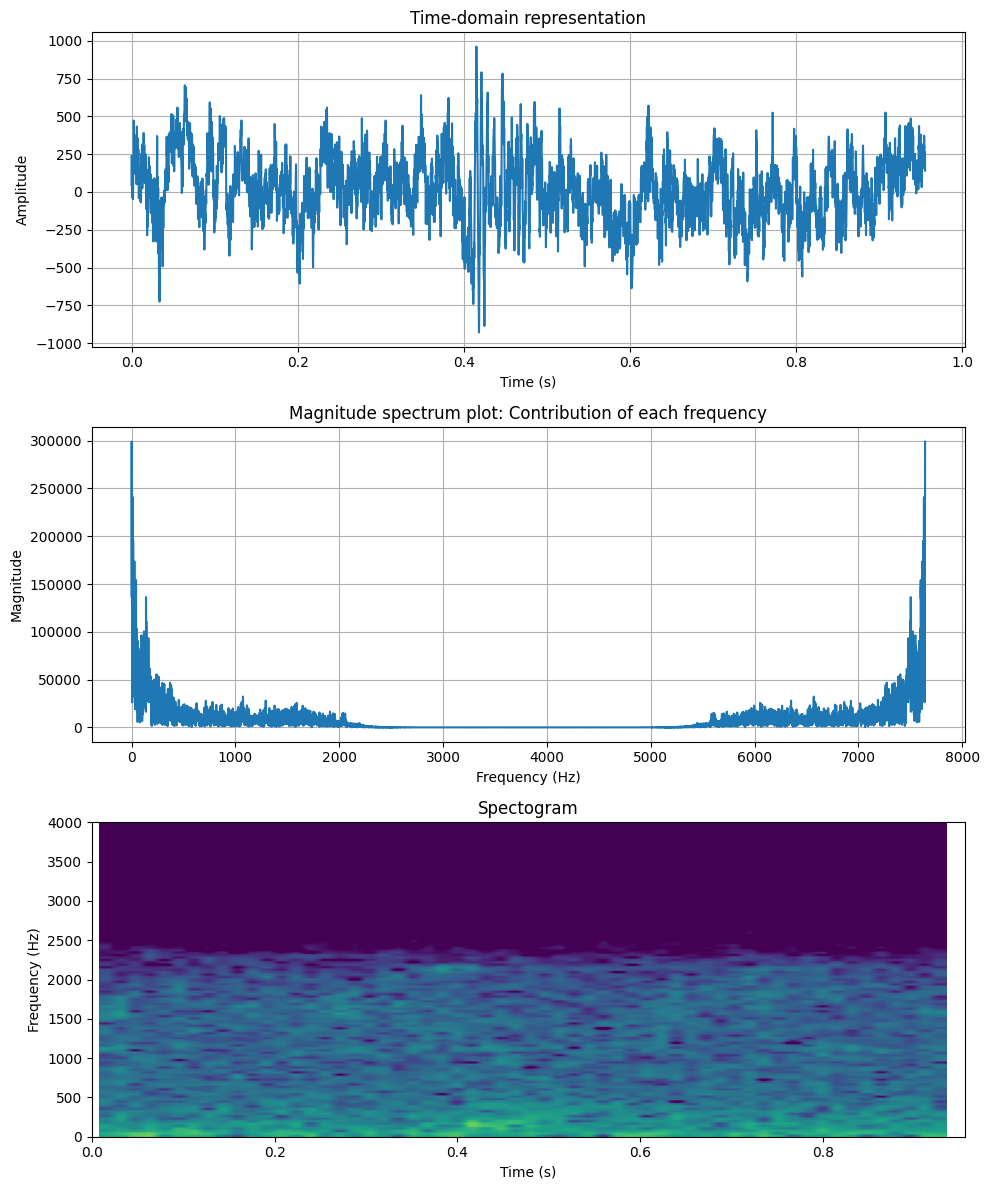

In [80]:
joint_plots('test.wav', 'watever')

# Now, let's check if the denoising is effective for clips that are shorther than 1 second


In [ ]:
def load_data(file_name):
    file_contents = tf.io.read_file(file_name) #retuns a string
    wave, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1) # transforms string into actual wav\n",
    wave = wave - tf.reduce_mean(wave) # remove the mean
    wave = tf.squeeze(wave, axis= -1) #removes axis
    wave = tf.cast(wave * 32768, tf.float32) # converting to int16

    return wave, sample_rate

In [ ]:
lengths = []
paths_smaller_1 = [] #145
paths_smaller_2 = [] # 329\n",
paths_smaller_3 = [] # 192\n",
paths_greater_10 = [] # 38\n",
counter = 0

In [ ]:
for file in os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code', 'data', 'Clips')):
    tensor_wave, sample_rate = load_data(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Clips', file))
    if len(tensor_wave)< 1*8000: 
        paths_smaller_1.append(file)
    elif len(tensor_wave)< 2*8000:
        paths_smaller_2.append(file)
    elif len(tensor_wave)< 3*8000:
        paths_smaller_3.append(file)
    elif len(tensor_wave)> 10*8000:
        paths_greater_10.append(file)
    lengths.append(len(tensor_wave))

## Inspecting spectograms to find out best cut off points for band pass filter  

In [ ]:
path_directory = os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Clips_denoised', 'differentiation'))
for file in path_directory[::5]:
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Clips_denoised/differentiation/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Images/denoised/differentiation/' + file.replace('.wav', '.jpg')
        joint_plots (file_name, destination_file)
   

In [ ]:
path_directory = os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Sounds_background_denoised', 'differentiation'))
for file in path_directory[::10]:
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_background_denoised/differentiation/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Images/denoised/differentiation/' + file.replace('.wav', '.jpg')
        joint_plots (file_name, destination_file)
   

In [ ]:
path_directory = os.listdir(os.path.join('/Users', 'rosameliacarioni','University','Thesis','code','data', 'Sounds_gunshots_denoised', 'differentiation'))
for file in path_directory[::10]:
    if '.wav' in file: 
        file_name = '/Users/rosameliacarioni/University/Thesis/code/data/Sounds_gunshots_denoised/differentiation/' + file
        destination_file = '/Users/rosameliacarioni/University/Thesis/code/data/Images/denoised/differentiation/' + file.replace('.wav', '.jpg')
        joint_plots (file_name, destination_file)
   